#Deep Learning Assignment-1
###Author: Rafeed Sultaan(s3763175)
#Task: Predicting the Tilt Angle from the Head Pose Image Dataset using Classification

##Loading the Dataset From Google Drive

In [ ]:
 from google.colab import drive 
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Extracting the A1_data.zip File

In [ ]:
#Unzipping the Dataset A1_data.zip
!cp  /content/drive/'My Drive'/COSC2779/Assignment01/A1_data.zip .
!unzip -q -o A1_data.zip
!rm A1_data.zip
!ls

drive	       modified_data.zip	 sample_data
__MACOSX       README.md		 test_data.csv
modified_data  s1234567_predictions.csv  train_data.csv


Extracting the images from modified_data.zip

In [ ]:
!unzip -q -o modified_data.zip
!rm modified_data.zip
!ls

drive	  modified_data  s1234567_predictions.csv  test_data.csv
__MACOSX  README.md	 sample_data		   train_data.csv


#Loading the Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

from PIL import Image

from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import concatenate
from keras.layers import LeakyReLU

from keras.utils import plot_model



from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle

from tensorflow import keras
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split



import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import pandas as pd
import keras
import keras as K
import glob
import tensorflow, tensorboard
import cv2
import imageio
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns



## Checking the contents of "train_data.csv" file which contains the image labels

In [ ]:

head_pose_data = pd.read_csv('train_data.csv',delimiter=',') 
head_pose_data.head(5)

,filename,person_id,series,tilt,pan
0,face_790.jpg,5,1,-15,30
1,face_2445.jpg,5,1,0,-75
2,face_2266.jpg,5,2,-15,-60
3,face_2713.jpg,5,2,0,-90
4,face_2016.jpg,5,2,15,-75


Dropping the "person_id" and "series" information which are not needed to predict the tilt angles


In [ ]:
head_pose_data = head_pose_data.drop(columns=['person_id', 'series'])

Checking the contents of the file after dropping the columns

In [ ]:
head_pose_data.head(10)

,filename,tilt,pan
0,face_790.jpg,-15,30
1,face_2445.jpg,0,-75
2,face_2266.jpg,-15,-60
3,face_2713.jpg,0,-90
4,face_2016.jpg,15,-75
5,face_2522.jpg,30,60
6,face_1254.jpg,15,-15
7,face_2754.jpg,15,-45
8,face_201.jpg,30,-90
9,face_931.jpg,15,-30


Checking the datatypes of the file name, tilt and pan

In [ ]:
head_pose_data.dtypes

filename    object
tilt         int64
pan          int64
dtype: object

Converting the tilt column from integer to string for classification

In [ ]:
head_pose_data['tilt'] = head_pose_data['tilt'].map(str)
head_pose_data['pan'] = head_pose_data['pan'].map(str)

Checking the data type of tilt and the pan

In [ ]:
head_pose_data.dtypes

filename    object
tilt        object
pan         object
dtype: object

Checking the range of values unique in "tilt"


In [ ]:
head_pose_data['tilt'].unique()

array(['-15', '0', '15', '30', '-60', '-30', '90', '60', '-90'],
      dtype=object)

## Converting the images to grayscale and resizing it to (64,64)


*   Color images are not needed to identify head poses
*   It will reduce the complexity of the images, allowing us to use deeper networks



In [ ]:

for filepath in glob.glob('modified_data/*.jpg', recursive=True):
    img = cv2.imread(filepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(gray, (64,64) , interpolation = cv2.INTER_AREA)
    img_resized.view
    cv2.imwrite(os.path.join(filepath), img_resized)

Preparing the dataframe with image_path and tilt labels



In [ ]:
image_list = []
for image_path in glob.glob("modified_data/*.jpg"):
    tokenized_image_path = image_path.split('/')
    #Got the filename from image_path by tokenizing
    filename = tokenized_image_path[1].strip()
    selectedRow = head_pose_data.loc[(head_pose_data['filename'] ==filename) ]
    # Selecting the images for the train set
    if selectedRow.empty == False:
      label = str(selectedRow.iloc[0]['tilt'])
      image_list.append((image_path, label))  
#dataframe consists of the data with only the training data containing image path and tilt labels
dataframe = pd.DataFrame(data=image_list, columns=['image_path','label'])



image_list_with_filenames = []
for image_path in glob.glob("modified_data/*.jpg"):
    filename = image_path.split("/")[-1]
    image_list_with_filenames.append((image_path,filename))
#dataframe consists of the all the data's image and filename
dataframe_with_filenames = pd.DataFrame(data=image_list_with_filenames,columns=["image_path","filename"])



Checking the contents of the dataframe, I am going to use for training my model

In [ ]:
dataframe.head(5)



,image_path,label
0,modified_data/face_2056.jpg,60
1,modified_data/face_994.jpg,-90
2,modified_data/face_731.jpg,-30
3,modified_data/face_2084.jpg,30
4,modified_data/face_784.jpg,15


# Checking the Distribution of classes in the dataframe

Amount of Images in each class

In [ ]:
print ("Number of -90 tilt poses " , len(dataframe[dataframe['label']=='-90']))
print ("Number of -60 tilt poses  " , len(dataframe[dataframe['label']=='-60']))
print ("Number of -30 tilt poses " , len(dataframe[dataframe['label']=='-30']))
print ("Number of -15 tilt poses  ",len(dataframe[dataframe['label']=='-15']))
print ("Number of 0 tilt poses ", len(dataframe[dataframe['label']=='0']))
print ("Number of 15 tilt poses ", len(dataframe[dataframe['label']=='15']))
print ("Number of 30 tilt poses ", len(dataframe[dataframe['label']=='30']))
print ("Number of 60 tilt poses ", len(dataframe[dataframe['label']=='60']))
print ("Number of 90 tilt poses ", len(dataframe[dataframe['label']=='90']))

Number of -90 tilt poses  25
Number of -60 tilt poses   325
Number of -30 tilt poses  325
Number of -15 tilt poses   325
Number of 0 tilt poses  325
Number of 15 tilt poses  325
Number of 30 tilt poses  325
Number of 60 tilt poses  325
Number of 90 tilt poses  25


### Bar Chart of Class Balance for Tilt Angles


*   Amount of the "-90" degrees class labels is significantly low compared to other classes
*   Amount of the "90" degrees class labels is significantly low compared to other classes



Text(0.5, 1.0, 'Class Balance Diagram for Tilt Angles')

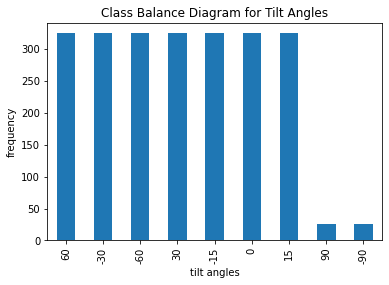

In [ ]:
ax = dataframe['label'].value_counts().plot(kind='bar')
ax.set_xlabel("tilt angles")
ax.set_ylabel("frequency")
ax.set_title("Class Balance Diagram for Tilt Angles")

Checking the images in the dataset, if the poses of the images can be recognized from the grayscale and resized images

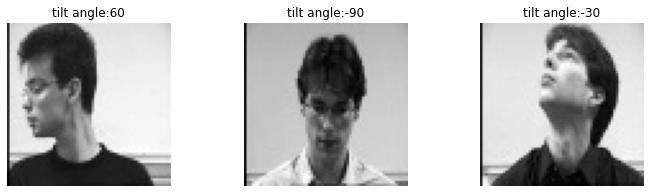

In [ ]:
from PIL import Image
random_image_list = dataframe.loc[np.random.choice(2325, 3),'image_path']
plt.figure(figsize=(12,3))
for i, image_path in enumerate(random_image_list ):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,3,i+1)
    plt.imshow(im,cmap='gray')
    plt.title("tilt angle:"+str(dataframe['label'][i]))
    plt.axis('off')  
plt.show()

#Using Holdout validation to split the data into train,test and validation sets 

In [ ]:
##Holdout data test_shapes
trainset, testset = train_test_split(dataframe, test_size=0.2)
trainset, validationset = train_test_split(trainset, test_size=0.2)

Amount of the data in the trainset,validationset and testset

In [ ]:
num_train_examples= trainset.shape[0]
num_val_examples = validationset.shape[0]
num_test_examples = testset.shape[0]

print("Number of data in the trainset:"+str(num_train_examples))
print("Number of data in the validationset:"+str(num_val_examples))
print("Number of data in the testset:"+str(num_test_examples ))



Number of data in the trainset:1488
Number of data in the validationset:372
Number of data in the testset:465


##Data Augmentation Using Vertical and Horizontal Shift in the trainset
* This is done to control overfitting of the data

*   Since we are dealing with rotations in headpose of data, it will change the  prediction of the images causing misclassification
*   Width-Shift range of 0.10 and Horizontal Shift range of 0.10 is used

## Creating the data for the model using  with Image_Data Generator
Experimented with other batch-size like [16,32,64] doesn't improve the 

*   Experimented with other batch-size like [16,32,64], doesn't improve the 
the performance.
*   Ended up taking BATCH_SIZE =16


In [ ]:
#Experimented with other batch-size like [16,32,64] doesn't improve the performance. So ended up taking batch size = 16 
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',width_shift_range=0.10,height_shift_range=0.10)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')



train_generator = train_datagen.flow_from_dataframe(
    dataframe=trainset,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(64,64),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=validationset,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(64,64),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testset,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(64,64),
    batch_size=BATCH_SIZE,
    shuffle = False,
    class_mode='categorical')

Found 1488 validated image filenames belonging to 9 classes.
Found 372 validated image filenames belonging to 9 classes.
Found 465 validated image filenames belonging to 9 classes.


evaluateModel() function prints Confution Matrix and Classification Report based on the test data from found from original head pose dataset

In [ ]:
def evaluateModel(model):
    test_generator.reset()
    Y_pred = model.predict_generator(test_generator)
    y_pred= np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(test_generator.classes, y_pred))
    print('Classification Report')
    target_names = ['-15', '-30', '-60', '-90', '0', '15', '30', '60', '90']
    print(classification_report(test_generator.classes, y_pred, target_names=target_names))

displayPlots() function displays the Validation Accuracy/Loss vs Epoch graphs

In [ ]:
def displayPlots(history):
    ## Accuracy Graph
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    ##Loss Graph
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

#LeNet with 2 Hidden Layers with SGD Optimizer 

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
activation_35 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_36 (Activation)   (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 6272)            

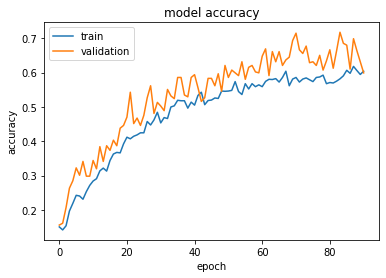

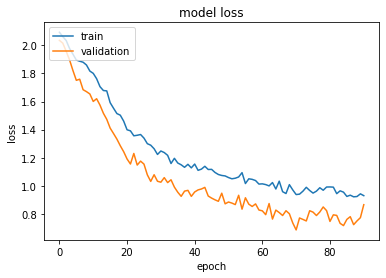

In [ ]:
LeNet1= Sequential()

# input
LeNet1.add(Input(shape=(64,64, 3)))
LeNet1.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

# input
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights


# Conv Layer 1
LeNet1.add(Conv2D(32, (3, 3)))
LeNet1.add(Activation('relu'))
LeNet1.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
LeNet1.add(Conv2D(32, (3, 3)))
LeNet1.add(Activation('relu'))
LeNet1.add(MaxPooling2D(pool_size=(2, 2)))




LeNet1.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
LeNet1.add(Dense(64))
LeNet1.add(Activation('relu'))
LeNet1.add(Dropout(0.5))
LeNet1.add(Dense(9))
LeNet1.add(Activation('softmax'))

LeNet1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=[categorical_accuracy])

LeNet1.summary()

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=LeNet1.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )
# Evaluate the model on the original dataset
evaluateModel(LeNet1)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#LeNet with 2 Hidden Layers with Adam Optimizer
*   Adam Optimizer is a variation of SGD with adaptive learning rate
*   Adam has less tuneable parameter like momentum. So I am making the choice of Adam for the rest of them
*   It converges faster, so to prove my point I did my experiment with my base model LeNet

* It converged at epoch 140 compared to SGD which was 175

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
activation_43 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_44 (Activation)   (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 14, 14, 32)      

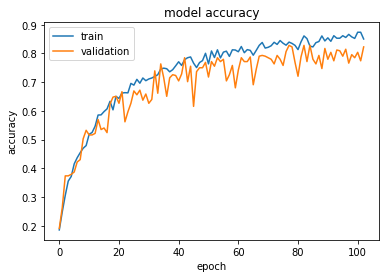

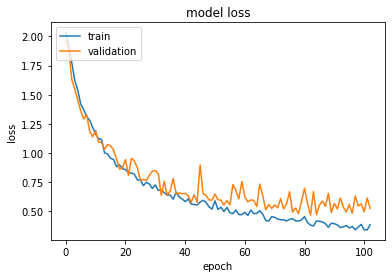

In [ ]:
LeNet2= Sequential()

# input
LeNet2.add(Input(shape=(64,64, 3)))
LeNet2.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

# Conv Layer 1
LeNet2.add(Conv2D(32, (3, 3)))
LeNet2.add(Activation('relu'))
LeNet2.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
LeNet2.add(Conv2D(32, (3, 3)))
LeNet2.add(Activation('relu'))
LeNet2.add(MaxPooling2D(pool_size=(2, 2)))




LeNet2.add(Flatten())  
LeNet2.add(Dense(64))
LeNet2.add(Activation('relu'))
LeNet2.add(Dense(9))
LeNet2.add(Activation('softmax'))

LeNet2.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=[categorical_accuracy])

LeNet2.summary()

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=LeNet2.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )
# Evaluate the model on the original dataset
evaluateModel(LeNet2)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

# LeNet with 2 Hidden Layers with Dropout Adam Optimizer
- Huge Gap between the training and validation loss, **underfitting**
- I need to increase the capacity of the model by increasing the number of layers

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
activation_39 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_40 (Activation)   (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 32)      

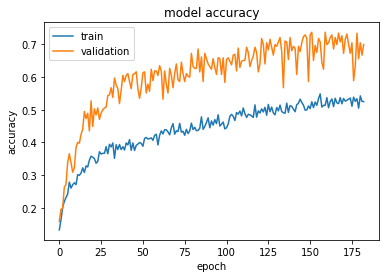

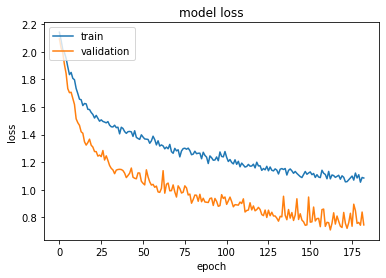

In [ ]:
LeNet3= Sequential()

# input
LeNet3.add(Input(shape=(64,64, 3)))
LeNet3.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 


# Conv Layer 1
LeNet3.add(Conv2D(32, (3, 3)))
LeNet3.add(Activation('relu'))
LeNet3.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
LeNet3.add(Conv2D(32, (3, 3)))
LeNet3.add(Activation('relu'))
LeNet3.add(MaxPooling2D(pool_size=(2, 2)))



LeNet3.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
LeNet3.add(Dense(64))
LeNet3.add(Activation('relu'))
LeNet3.add(Dropout(0.5))
LeNet3.add(Dense(9))
LeNet3.add(Activation('softmax'))

LeNet3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

LeNet3.summary()

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=LeNet3.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )
# Evaluate the model on the original dataset
evaluateModel(LeNet3)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#LeNet with 3 Hidden Layers Dropout Adam Optimizer
- Dropout is used to make sure the network doesn't overfit even after adding more capacity
- Highest weighted average F1 Score 0.89 was chieve

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
activation_24 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
activation_25 (Activation)   (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)       

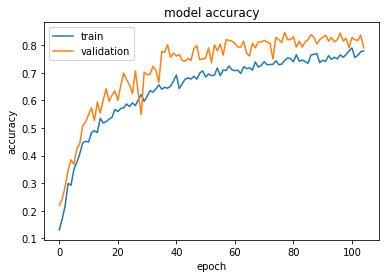

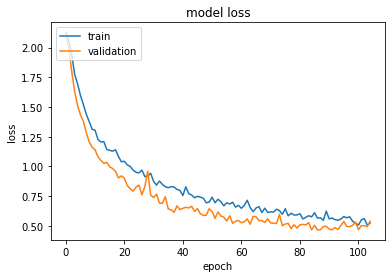

In [ ]:
LeNet4= Sequential()

# input
LeNet4.add(Input(shape=(64,64, 3)))

LeNet4.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
LeNet4.add(Conv2D(32, (3, 3)))
LeNet4.add(Activation('relu'))
LeNet4.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
LeNet4.add(Conv2D(32, (3, 3)))
LeNet4.add(Activation('relu'))
LeNet4.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 3 
LeNet4.add(Conv2D(64, (3, 3)))
LeNet4.add(Activation('relu'))
LeNet4.add(MaxPooling2D(pool_size=(2, 2)))


LeNet4.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
LeNet4.add(Dense(64))
LeNet4.add(Activation('relu'))
LeNet4.add(Dropout(0.5))
LeNet4.add(Dense(9))
LeNet4.add(Activation('softmax'))

LeNet4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

LeNet4.summary()

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=LeNet4.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )

# Evaluate the model on the original dataset
evaluateModel(LeNet4)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

# LeNet with 3 hidden layers ADAM Optimizer Dropout  L2 Regularization and Leaky Relu
- L2 regularization is used just to make sure the model doesn't overfit, doesn't overfit even after adding more capacity

- Dropout is also used to make sure the the model doesn't overfit
- The perfomance is poorer if i use Leaky Relu, so I will stick to Relu activation function

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_14 (Lambda)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 14, 14, 32)      

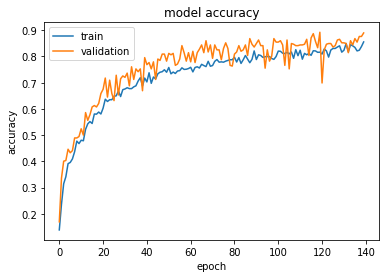

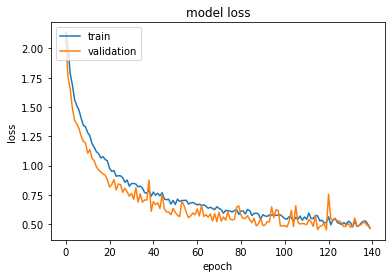

In [ ]:

#Leadky relu alpha value 0.1 is the most popular hyper parameter
leaky_relu_alpha = 0.1

LeNet5= Sequential()

# input
LeNet5.add(Input(shape=(64,64, 3)))
LeNet5.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 


# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
LeNet5.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
LeNet5.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet5.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
LeNet5.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
LeNet5.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet5.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 3 
LeNet5.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
LeNet5.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet5.add(MaxPooling2D(pool_size=(2, 2)))

#fully connected layer
LeNet5.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
LeNet5.add(Dense(64))
LeNet5.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet5.add(Dropout(0.5))
LeNet5.add(Dense(9))
LeNet5.add(Activation('softmax'))

LeNet5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

LeNet5.summary()

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=LeNet5.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )

# Evaluate the model on the original dataset
evaluateModel(LeNet5)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#LeNet with 4 hidden layers Adam Optimizer and Leaky Relu L2 Regularization
- The model **overfits** . 
- The previous model  LeNet with 3 hidden layers ADAM Optimizer Dropout L2 Regularization Leaky Relu was better

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_15 (Lambda)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 29, 29, 32)        0         
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 14, 14, 32)      

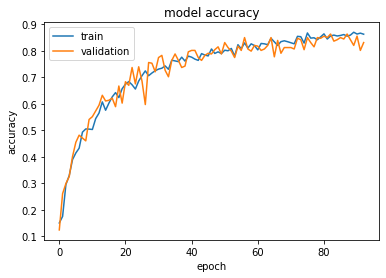

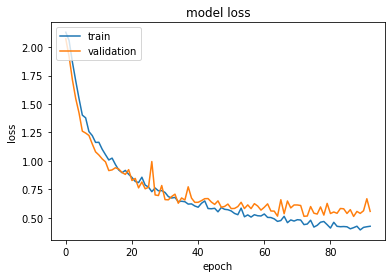

In [ ]:
#Leadky relu alpha value 0.1 is the most popular hyper parameter
leaky_relu_alpha = 0.1

LeNet6= Sequential()

# input
LeNet6.add(Input(shape=(64,64, 3)))

LeNet6.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
LeNet6.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
LeNet6.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet6.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
LeNet6.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
LeNet6.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet6.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 3 
LeNet6.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
LeNet6.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet6.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 4
LeNet6.add(Conv2D(64, (3, 3)))
LeNet6.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet6.add(MaxPooling2D(pool_size=(2, 2)))



LeNet6.add(Flatten()) 
#Fully Connected Layer
LeNet6.add(Dense(64))
LeNet6.add(LeakyReLU(alpha=leaky_relu_alpha))
LeNet6.add(Dropout(0.5))
LeNet6.add(Dense(9))
LeNet6.add(Activation('softmax'))

LeNet6.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

LeNet6.summary()

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=LeNet6.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )

# Evaluate the model on the original dataset
evaluateModel(LeNet6)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#VGG with 2 VGG Blocks,SGD Optimizer,Dropout,Relu Activation
- The model is underfitting, need to increase capacity.
- Performs better than LeNet
- Next model, I will try with Adam Optimizer

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_16 (Lambda)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 1024)            

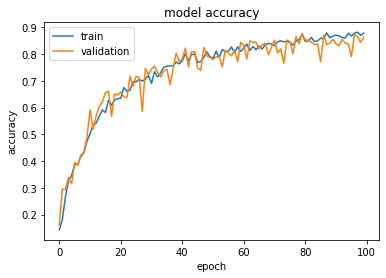

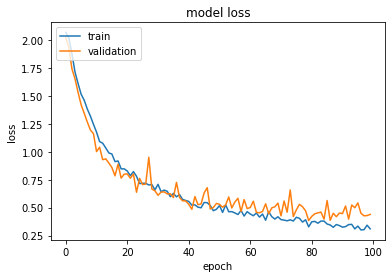

In [ ]:
model_vgg_2VGGBlocks= Sequential()
model_vgg_2VGGBlocks.add(Input(shape=(64,64, 3)))
model_vgg_2VGGBlocks.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

#VGG BLOCK 1
model_vgg_2VGGBlocks.add(Conv2D(64, (3, 3),activation='relu'))
model_vgg_2VGGBlocks.add(MaxPooling2D(pool_size=(2, 2)))
#VGG BLOCK 2
model_vgg_2VGGBlocks.add(Conv2D(64, (3, 3),activation='relu'))
model_vgg_2VGGBlocks.add(MaxPooling2D(pool_size=(2, 2)))

#Fully Connected Layer 1

model_vgg_2VGGBlocks.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_vgg_2VGGBlocks.add(Dense(1024))
model_vgg_2VGGBlocks.add(Activation('relu'))

#Fully Connected Layer 2
model_vgg_2VGGBlocks.add(Dense(1024))
model_vgg_2VGGBlocks.add(Activation('relu'))


model_vgg_2VGGBlocks.add(Dropout(0.5))
model_vgg_2VGGBlocks.add(Dense(9))
model_vgg_2VGGBlocks.add(Activation('softmax'))


model_vgg_2VGGBlocks.summary()


model_vgg_2VGGBlocks.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=[categorical_accuracy])
# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_vgg_2VGGBlocks.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )

# Evaluate the model on the original dataset
evaluateModel(model_vgg_2VGGBlocks)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#VGG with 2 VGG Blocks with Adam Optimizer Relu Activation Function
- The model is underfitting going to increase capacity by increasing the vgg blocks from 2 to 3 next.

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_17 (Lambda)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 1024)            

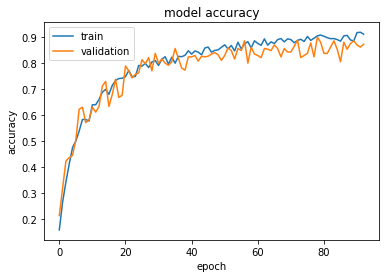

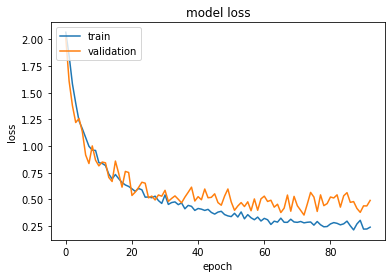

In [ ]:
model_vgg_2VGGBlocks= Sequential()
model_vgg_2VGGBlocks.add(Input(shape=(64,64, 3)))
model_vgg_2VGGBlocks.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

#VGG BLOCK 1
model_vgg_2VGGBlocks.add(Conv2D(64, (3, 3),activation='relu'))
model_vgg_2VGGBlocks.add(MaxPooling2D(pool_size=(2, 2)))
#VGG BLOCK 2
model_vgg_2VGGBlocks.add(Conv2D(64, (3, 3),activation='relu'))
model_vgg_2VGGBlocks.add(MaxPooling2D(pool_size=(2, 2)))

#Fully Connected Layer 1

model_vgg_2VGGBlocks.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_vgg_2VGGBlocks.add(Dense(1024))
model_vgg_2VGGBlocks.add(Activation('relu'))

#Fully Connected Layer 2
model_vgg_2VGGBlocks.add(Dense(1024))
model_vgg_2VGGBlocks.add(Activation('relu'))


model_vgg_2VGGBlocks.add(Dropout(0.5))
model_vgg_2VGGBlocks.add(Dense(9))
model_vgg_2VGGBlocks.add(Activation('softmax'))


model_vgg_2VGGBlocks.summary()


model_vgg_2VGGBlocks.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])
# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_vgg_2VGGBlocks.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )

# Evaluate the model on the original dataset
evaluateModel(model_vgg_2VGGBlocks)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#VGG with 3 VGG Blocks with Dropout
- The model is **overfitting** need to use Regularization next

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_9 (Lambda)            (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 14, 14, 64)       

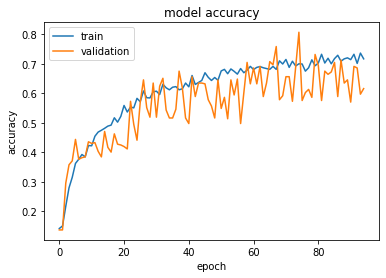

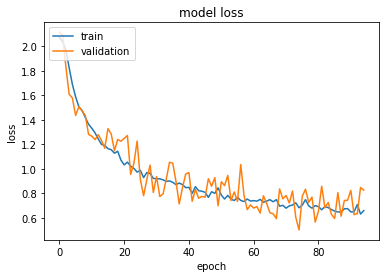

In [ ]:

model_vgg_3VGGblocks= Sequential()
model_vgg_3VGGblocks.add(Input(shape=(64,64, 3)))
model_vgg_3VGGblocks.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

#VGG BLOCK 1
model_vgg_3VGGblocks.add(Conv2D(64, (3, 3),activation='relu'))
model_vgg_3VGGblocks.add(MaxPooling2D(pool_size=(2, 2)))
model_vgg_3VGGblocks.add(Dropout(0.5))
#VGG BLOCK 2
model_vgg_3VGGblocks.add(Conv2D(64, (3, 3),activation='relu'))
model_vgg_3VGGblocks.add(MaxPooling2D(pool_size=(2, 2)))
model_vgg_3VGGblocks.add(Dropout(0.5))
#VGG BLOCK 3
model_vgg_3VGGblocks.add(Conv2D(64, (3, 3),activation='relu'))
model_vgg_3VGGblocks.add(MaxPooling2D(pool_size=(2, 2)))
model_vgg_3VGGblocks.add(Dropout(0.5))
#Fully Connected Layer 1

model_vgg_3VGGblocks.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_vgg_3VGGblocks.add(Dense(512))
model_vgg_3VGGblocks.add(Activation('relu'))

#Fully Connected Layer 2
model_vgg_3VGGblocks.add(Dense(512))
model_vgg_3VGGblocks.add(Activation('relu'))


model_vgg_3VGGblocks.add(Dropout(0.5))
model_vgg_3VGGblocks.add(Dense(9))
model_vgg_3VGGblocks.add(Activation('softmax'))


model_vgg_3VGGblocks.summary()


model_vgg_3VGGblocks.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])
# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_vgg_3VGGblocks.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0
                    )

# Evaluate the model on the original dataset
evaluateModel(model_vgg_3VGGblocks)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#Model VGG 3 Blocks with Adam Optimizer Dropout L2 Regularization
- After experimenting with alpha [0.1,0.01,0.001,0.0001], alpha = 0.001 was found to be the best
- Using Random Search to tune parameter lamba/alpha of regularization
- The results are really bad, it is better to not use l2 regularization after observing this experiment.

Alpha:0.0005
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_28 (Lambda)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 14, 

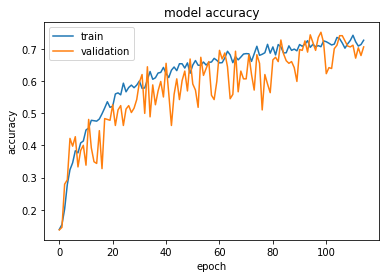

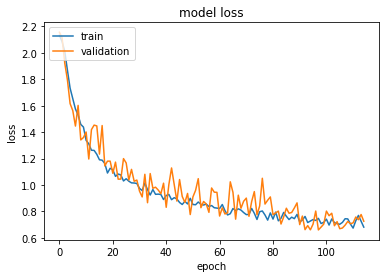

Alpha:0.0001
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_29 (Lambda)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 14, 

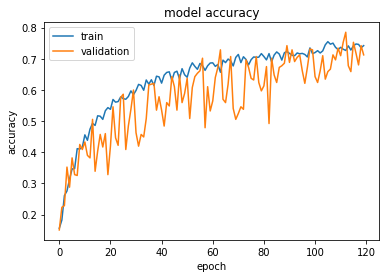

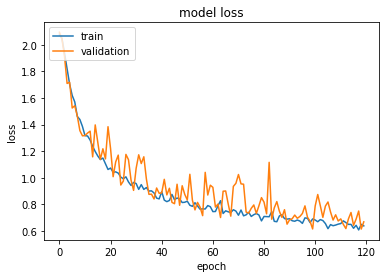

Alpha:5e-05
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_30 (Lambda)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 14, 1

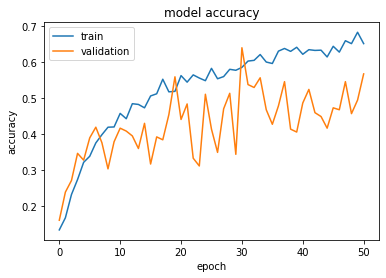

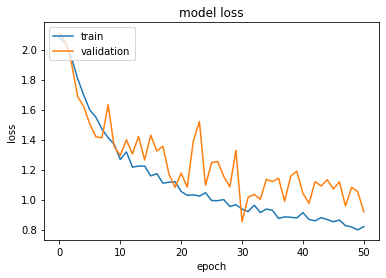

In [ ]:
alpha_list = [0.0005,0.0001,0.00005]
for alpha in alpha_list:
  print("Alpha:"+str(alpha))
  model_vgg_3VGGblocks_L2Reg= Sequential()
  model_vgg_3VGGblocks_L2Reg.add(Input(shape=(64,64, 3)))
  model_vgg_3VGGblocks_L2Reg.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

  #VGG BLOCK 1
  model_vgg_3VGGblocks_L2Reg.add(Conv2D(64, (3, 3),activation='relu',kernel_regularizer=regularizers.l2(alpha)))
  model_vgg_3VGGblocks_L2Reg.add(MaxPooling2D(pool_size=(2, 2)))
  model_vgg_3VGGblocks_L2Reg.add(Dropout(0.5))
  #VGG BLOCK 2
  model_vgg_3VGGblocks_L2Reg.add(Conv2D(64, (3, 3),activation='relu',kernel_regularizer=regularizers.l2(alpha)))
  model_vgg_3VGGblocks_L2Reg.add(MaxPooling2D(pool_size=(2, 2)))
  model_vgg_3VGGblocks_L2Reg.add(Dropout(0.5))
  #VGG BLOCK 3
  model_vgg_3VGGblocks_L2Reg.add(Conv2D(64, (3, 3),activation='relu',kernel_regularizer=regularizers.l2(alpha)))
  model_vgg_3VGGblocks_L2Reg.add(MaxPooling2D(pool_size=(2, 2)))
  model_vgg_3VGGblocks_L2Reg.add(Dropout(0.5))
  #Fully Connected Layer 1

  model_vgg_3VGGblocks_L2Reg.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  model_vgg_3VGGblocks_L2Reg.add(Dense(512))
  model_vgg_3VGGblocks_L2Reg.add(Activation('relu'))

  #Fully Connected Layer 2
  model_vgg_3VGGblocks_L2Reg.add(Dense(512))
  model_vgg_3VGGblocks_L2Reg.add(Activation('relu'))


  model_vgg_3VGGblocks_L2Reg.add(Dropout(0.5))
  model_vgg_3VGGblocks_L2Reg.add(Dense(9))
  model_vgg_3VGGblocks_L2Reg.add(Activation('softmax'))


  model_vgg_3VGGblocks_L2Reg.summary()


  model_vgg_3VGGblocks_L2Reg.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=[categorical_accuracy])
  # Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
  monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
  history=model_vgg_3VGGblocks_L2Reg.fit_generator(generator=train_generator,
                      validation_data=validation_generator,
                      callbacks=[monitor],
                      epochs=250,
                      verbose=0
                      )

  # Evaluate the model on the original dataset
  evaluateModel(model_vgg_3VGGblocks_L2Reg)
  # Display Training Validation Accuracy and Loss Graphs
  displayPlots(history)

#Resnet Model


Defining Residual Block Class 
- Did not use the bottleneck layer because because my image shape is (64,64,1), by using only 4 residual block my Resnet starts to overfit.
- The bottle neck in general is used for very deep networks like Resnet. In a shallow network like the one I am using for this project won't make much of a difference. 

In [ ]:
class ResidualBlock(tf.keras.layers.Layer):

    # Initialize components of the model
    def __init__(self, filter_num, stride=1, reg_lambda=0.0):
        super(ResidualBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            kernel_initializer="he_normal",
                                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization(momentum=.4)
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            kernel_initializer="he_normal",
                                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization(momentum=.4)
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       kernel_initializer="he_normal",
                                                       kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization(momentum=.4))
        else:
            self.downsample = lambda x: x

    # Define the forward function
    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'conv1': self.conv1,
            'bn1': self.bn1,
            'conv2': self.conv2,
            'bn2': self.bn2,
            'downsample': self.downsample,
        })
        return config

## get_resnet_model() generates the resnet model based on filters list and blocks list
- Had to modify it to handle 1 Channel images

In [ ]:
def get_resnet_model(filters, block_size, reg_lambda=0.0, fdropout=False):
  model = tf.keras.Sequential()

  #initial segment
  model.add(tf.keras.layers.Conv2D(filters=64,
                                   kernel_size=(3, 3),
                                   strides=1,
                                   kernel_initializer="he_normal",
                                   kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                   padding="same", input_shape=(64,64, 3)))
  #Modification for handling one channel images
  model.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
  model.add(tf.keras.layers.BatchNormalization(momentum=.4))

  #Stack of residual blocks
  for nFilters, nBlocks in zip(filters, block_size):
    model.add(ResidualBlock(nFilters, stride=2, reg_lambda=reg_lambda))
    
    for _ in range(1, nBlocks):
      model.add(ResidualBlock(nFilters, stride=1, reg_lambda=reg_lambda))

  # Final part
  model.add(tf.keras.layers.GlobalAveragePooling2D())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(9, 
                                  activation=tf.nn.softmax, 
                                  kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                  kernel_initializer="he_normal"))

  return model

#Resnet Model with 6 Residual Blocks with SGD Optimizer with L2 Regularization
- Using  Lambda Value =0.001

Restoring model weights from the end of the best epoch.
Epoch 00177: early stopping
Confusion Matrix
[[58  3  0  0  1  0  0  0  0]
 [ 0 56  5  0  0  0  0  0  0]
 [ 0  0 62  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0]
 [ 1  0  0  0 62  1  0  0  0]
 [ 0  0  0  0  0 75  1  0  0]
 [ 0  0  0  0  0  2 58  0  0]
 [ 0  0  0  0  0  0  0 72  0]
 [ 0  0  0  0  0  0  0  0  5]]
Classification Report
              precision    recall  f1-score   support

         -15       0.98      0.94      0.96        62
         -30       0.95      0.92      0.93        61
         -60       0.89      1.00      0.94        62
         -90       0.00      0.00      0.00         3
           0       0.98      0.97      0.98        64
          15       0.96      0.99      0.97        76
          30       0.98      0.97      0.97        60
          60       1.00      1.00      1.00        72
          90       1.00      1.00      1.00         5

    accuracy                           0.96       465
   macro a

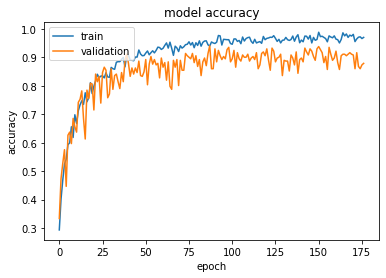

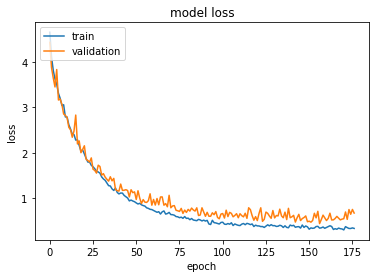

In [ ]:
model_resnet_2 = get_resnet_model([64, 128], [3, 3], reg_lambda=0.001)

model_resnet_2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=[categorical_accuracy])

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_resnet_2.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0)

# Evaluate the model on the original dataset
evaluateModel(model_resnet_2)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

# Resnet Model with 6 Residual Blocks with Adam Optimizer with L2 Regularization
- Lambda value 0.001 was chosen after hyper parameter tuning.

Restoring model weights from the end of the best epoch.
Epoch 00146: early stopping
Confusion Matrix
[[58  4  0  0  0  0  0  0  0]
 [ 1 52  8  0  0  0  0  0  0]
 [ 0  0 62  0  0  0  0  0  0]
 [ 0  0  2  1  0  0  0  0  0]
 [ 2  0  0  0 60  2  0  0  0]
 [ 0  0  0  0  1 69  6  0  0]
 [ 0  0  0  0  0  0 60  0  0]
 [ 0  0  0  0  0  0  0 71  1]
 [ 0  0  0  0  0  0  0  0  5]]
Classification Report
              precision    recall  f1-score   support

         -15       0.95      0.94      0.94        62
         -30       0.93      0.85      0.89        61
         -60       0.86      1.00      0.93        62
         -90       1.00      0.33      0.50         3
           0       0.98      0.94      0.96        64
          15       0.97      0.91      0.94        76
          30       0.91      1.00      0.95        60
          60       1.00      0.99      0.99        72
          90       0.83      1.00      0.91         5

    accuracy                           0.94       465
   macro a

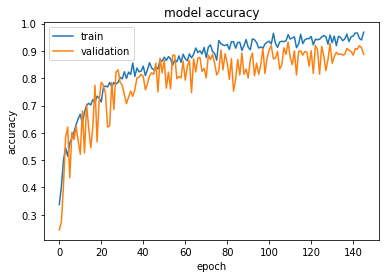

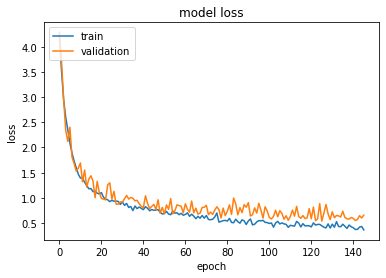

In [ ]:
model_resnet_2_ADAM = get_resnet_model([64, 128], [3, 3], reg_lambda=0.001)

model_resnet_2_ADAM.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=[categorical_accuracy])

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_resnet_2_ADAM.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0)

# Evaluate the model on the original dataset
evaluateModel(model_resnet_2_ADAM)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

# ResNet Model with 9 Residual Blocks with Adam Optimizer with L2 Regularization
- Lambda value 0.001 was chosen after hyper parameter tuning.
- Highest weighted average F1-Score of 0.95 for tilt angle prediction was achieved

Restoring model weights from the end of the best epoch.
Epoch 00129: early stopping
Confusion Matrix
[[62  0  0  0  0  0  0  0  0]
 [ 3 56  1  1  0  0  0  0  0]
 [ 0  1 61  0  0  0  0  0  0]
 [ 0  0  1  2  0  0  0  0  0]
 [ 3  0  0  0 61  0  0  0  0]
 [ 0  0  0  0  5 66  5  0  0]
 [ 0  0  0  0  0  2 58  0  0]
 [ 0  0  0  0  0  0  0 70  2]
 [ 0  0  0  0  0  0  0  0  5]]
Classification Report
              precision    recall  f1-score   support

         -15       0.91      1.00      0.95        62
         -30       0.98      0.92      0.95        61
         -60       0.97      0.98      0.98        62
         -90       0.67      0.67      0.67         3
           0       0.92      0.95      0.94        64
          15       0.97      0.87      0.92        76
          30       0.92      0.97      0.94        60
          60       1.00      0.97      0.99        72
          90       0.71      1.00      0.83         5

    accuracy                           0.95       465
   macro a

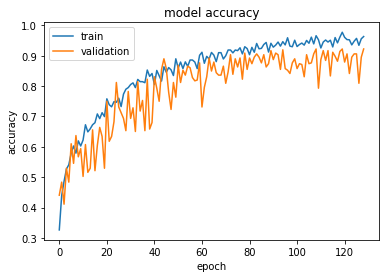

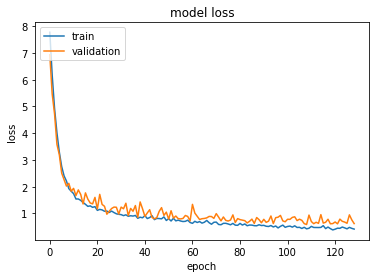

In [ ]:
model_resnet3 = get_resnet_model([64, 128, 256], [3, 3, 3], reg_lambda=0.001)

model_resnet3.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=[categorical_accuracy])

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_resnet3.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0)

# Evaluate the model on the original dataset
evaluateModel(model_resnet3)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

# ResNet Model with 12 Residual Blocks with Adam Optimizer with L2 Regularization

> Indented block


- Lambda value 0.001 was chosen after hyper parameter tuning
- A shallower network ResNet with 3 Blocks has weighted F1-score of 0.95 

Restoring model weights from the end of the best epoch.
Epoch 00149: early stopping
Confusion Matrix
[[55  5  0  0  2  0  0  0  0]
 [ 0 61  0  0  0  0  0  0  0]
 [ 0  5 56  1  0  0  0  0  0]
 [ 0  0  1  2  0  0  0  0  0]
 [ 4  0  0  0 58  2  0  0  0]
 [ 0  0  0  0  2 69  5  0  0]
 [ 0  0  0  0  0  4 55  1  0]
 [ 0  0  0  0  0  0  0 71  1]
 [ 0  0  0  1  0  0  0  0  4]]
Classification Report
              precision    recall  f1-score   support

         -15       0.93      0.89      0.91        62
         -30       0.86      1.00      0.92        61
         -60       0.98      0.90      0.94        62
         -90       0.50      0.67      0.57         3
           0       0.94      0.91      0.92        64
          15       0.92      0.91      0.91        76
          30       0.92      0.92      0.92        60
          60       0.99      0.99      0.99        72
          90       0.80      0.80      0.80         5

    accuracy                           0.93       465
   macro a

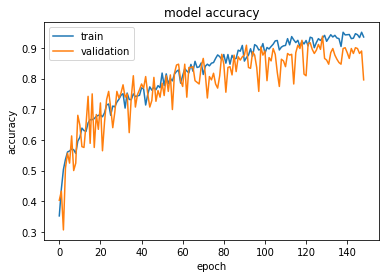

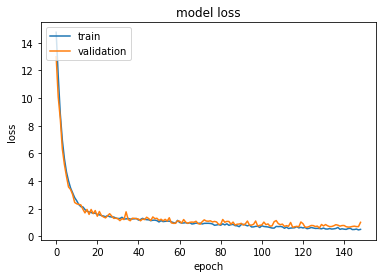

In [ ]:
model_resnet4 = get_resnet_model([64, 128, 256,512], [3, 3, 3,3], reg_lambda=0.001)

model_resnet4.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=[categorical_accuracy])

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=model_resnet4.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0)

# Evaluate the model on the original dataset
evaluateModel(model_resnet4)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)

#Using Random Search Hyper Parameter Tuning Resnet with 9 Residual Blocks
- The best model til now lambda value 0.001 gives highest weighted F1-Score of 0.96

lambda=0.01
Restoring model weights from the end of the best epoch.
Epoch 00130: early stopping
Confusion Matrix
[[53  8  0  0  1  0  0  0  0]
 [ 7 51  3  0  0  0  0  0  0]
 [ 0  3 59  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0]
 [12  0  0  0 51  1  0  0  0]
 [ 0  0  0  0 10 62  4  0  0]
 [ 0  0  0  0  0  8 51  1  0]
 [ 0  0  0  0  0  0  0 67  5]
 [ 0  0  1  0  0  0  0  0  4]]
Classification Report
              precision    recall  f1-score   support

         -15       0.74      0.85      0.79        62
         -30       0.82      0.84      0.83        61
         -60       0.89      0.95      0.92        62
         -90       0.00      0.00      0.00         3
           0       0.82      0.80      0.81        64
          15       0.87      0.82      0.84        76
          30       0.93      0.85      0.89        60
          60       0.99      0.93      0.96        72
          90       0.44      0.80      0.57         5

    accuracy                           0.86       46

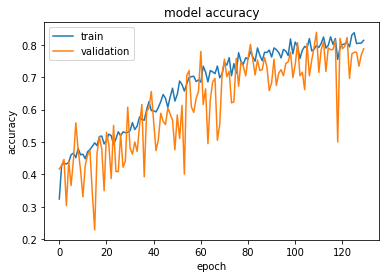

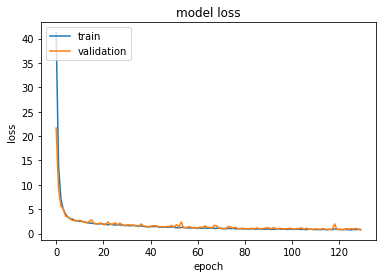

lambda=0.001
Restoring model weights from the end of the best epoch.
Epoch 00135: early stopping
Confusion Matrix
[[58  3  0  0  1  0  0  0  0]
 [ 1 55  5  0  0  0  0  0  0]
 [ 0  0 62  0  0  0  0  0  0]
 [ 0  0  2  1  0  0  0  0  0]
 [ 1  0  0  0 63  0  0  0  0]
 [ 0  0  0  0  2 71  3  0  0]
 [ 0  0  0  0  0  0 60  0  0]
 [ 0  0  0  0  0  0  0 71  1]
 [ 0  0  0  0  0  0  0  0  5]]
Classification Report
              precision    recall  f1-score   support

         -15       0.97      0.94      0.95        62
         -30       0.95      0.90      0.92        61
         -60       0.90      1.00      0.95        62
         -90       1.00      0.33      0.50         3
           0       0.95      0.98      0.97        64
          15       1.00      0.93      0.97        76
          30       0.95      1.00      0.98        60
          60       1.00      0.99      0.99        72
          90       0.83      1.00      0.91         5

    accuracy                           0.96       4

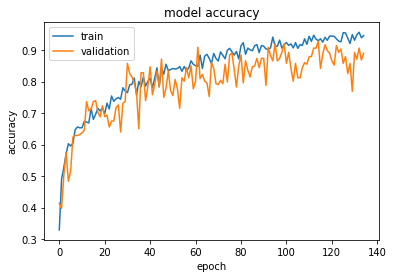

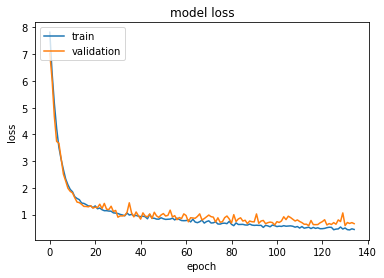

lambda=0.0001
Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
Confusion Matrix
[[44 12  0  0  6  0  0  0  0]
 [ 2 58  1  0  0  0  0  0  0]
 [ 0  4 56  2  0  0  0  0  0]
 [ 0  0  2  1  0  0  0  0  0]
 [ 4  0  0  0 59  1  0  0  0]
 [ 0  0  0  0  1 73  2  0  0]
 [ 0  0  0  0  0  1 58  1  0]
 [ 0  0  0  0  0  0  0 71  1]
 [ 0  0  0  0  0  0  0  0  5]]
Classification Report
              precision    recall  f1-score   support

         -15       0.88      0.71      0.79        62
         -30       0.78      0.95      0.86        61
         -60       0.95      0.90      0.93        62
         -90       0.33      0.33      0.33         3
           0       0.89      0.92      0.91        64
          15       0.97      0.96      0.97        76
          30       0.97      0.97      0.97        60
          60       0.99      0.99      0.99        72
          90       0.83      1.00      0.91         5

    accuracy                           0.91       

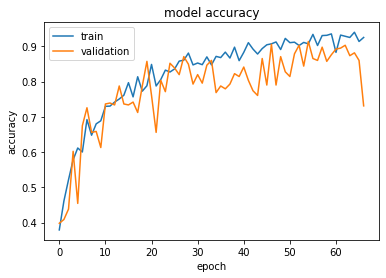

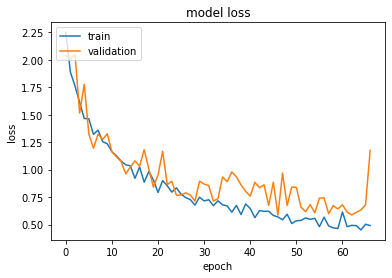

In [ ]:
lambda_vals = [0.01,0.001,0.0001]

for reg_lambda in lambda_vals:
  print("lambda="+str(reg_lambda))
  model_resnet = get_resnet_model([64, 128, 256], [3, 3, 3], reg_lambda=reg_lambda)

  model_resnet.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=[categorical_accuracy])

  # Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
  monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
  history=model_resnet.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0)

  # Evaluate the model on the original dataset
  evaluateModel(model_resnet)
  # Display Training Validation Accuracy and Loss Graphs
  displayPlots(history)



#Final Model Selected Resnet with 9 Residual Blocks with Adam Optimizer L2 Regularization
- The hyperparameter lambda =0.001 gives the best result

Restoring model weights from the end of the best epoch.
Epoch 00119: early stopping
Confusion Matrix
[[53  6  0  0  3  0  0  0  0]
 [ 1 56  4  0  0  0  0  0  0]
 [ 0  1 60  1  0  0  0  0  0]
 [ 0  0  2  1  0  0  0  0  0]
 [ 0  0  0  0 63  1  0  0  0]
 [ 0  0  0  0  5 65  6  0  0]
 [ 0  0  0  0  0  3 55  2  0]
 [ 0  0  0  0  0  0  0 72  0]
 [ 0  0  0  0  0  0  0  0  5]]
Classification Report
              precision    recall  f1-score   support

         -15       0.98      0.85      0.91        62
         -30       0.89      0.92      0.90        61
         -60       0.91      0.97      0.94        62
         -90       0.50      0.33      0.40         3
           0       0.89      0.98      0.93        64
          15       0.94      0.86      0.90        76
          30       0.90      0.92      0.91        60
          60       0.97      1.00      0.99        72
          90       1.00      1.00      1.00         5

    accuracy                           0.92       465
   macro a

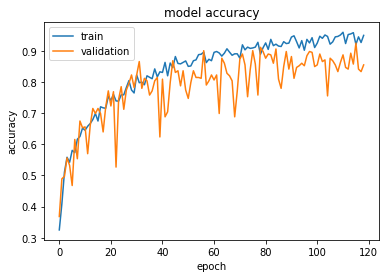

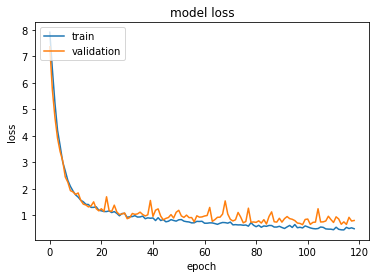

In [ ]:
final_model = get_resnet_model([64, 128, 256], [3, 3, 3], reg_lambda=0.001)
final_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[categorical_accuracy])

# Early Stopping based on validation loss, minimum differece training loss and validation loss is 0.001, epoch 20
monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=20,verbose=1,restore_best_weights=True)
history=final_model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    callbacks=[monitor],
                    epochs=250,
                    verbose=0)

# Evaluate the model on the original dataset
evaluateModel(final_model)
# Display Training Validation Accuracy and Loss Graphs
displayPlots(history)


# Predicting the testing dataset

Checking the "test_data.csv" contents

In [ ]:
head_pose_test_data = pd.read_csv('test_data.csv',delimiter=',') 
head_pose_test_data.head(5)

,filename,person_id,series
0,face_33.jpg,2,1
1,face_2148.jpg,2,2
2,face_2119.jpg,2,1
3,face_1262.jpg,2,1
4,face_516.jpg,2,2


Merging the dataframe based on "filename" to prepare the dataframe to feed it to the image generator

In [ ]:
temp_df = pd.merge(head_pose_test_data,dataframe_with_filenames,on="filename")

Preparing the dataframe to feed it to the image generator
and dropping the "person_id" and "series" column because they are unneccessary

In [ ]:
prediction_df = temp_df.drop(columns=['person_id', 'series'])
prediction_df.head(5)

,filename,person_id,series,image_path
0,face_33.jpg,2,1,modified_data/face_33.jpg
1,face_2148.jpg,2,2,modified_data/face_2148.jpg
2,face_2119.jpg,2,1,modified_data/face_2119.jpg
3,face_1262.jpg,2,1,modified_data/face_1262.jpg
4,face_516.jpg,2,2,modified_data/face_516.jpg


### Creating the testgenerator for test data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
predictionTestData_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
batch_size = 16


predictionTestDataGenerator = predictionTestData_datagen.flow_from_dataframe(
        dataframe=prediction_df,
        directory='./',
        x_col="image_path",
        y_col="filename",
        target_size=(64,64),
        batch_size=batch_size,
        shuffle = False,
        class_mode='categorical')

Found 465 validated image filenames belonging to 465 classes.


### Processing the Predictions

In [ ]:
predictions = final_model.predict_generator(predictionTestDataGenerator)


prediction_list = []
for i in range(0,len(predictions[:,0])):
  prediction_list.append(np.argmax(predictions[i]))
labels_predicted = np.asarray(prediction_list)


# Assigning the predictions with the appropriate labels
for i,j in enumerate(labels_predicted):
  if j ==0:
    labels_predicted[i] = "-15"
  if j ==1:
    labels_predicted[i] = '-30'
  if j ==2:
    labels_predicted[i] = '-60'
  if j ==3:
    labels_predicted[i] = '-90'
  if j ==4:
    labels_predicted[i] = '0'
  if j ==5:
    labels_predicted[i] = '15'
  if j ==6:
    labels_predicted[i] = '30'
  if j ==7:
    labels_predicted[i] = '60'
  if j ==8:
    labels_predicted[i] = '90'

print(labels_predicted)

[ 60 -60 -15  15 -60 -60  60  60  60 -90 -90  60  15  30 -30 -30   0  60
 -60 -60 -60  60  30  60 -60  90 -60  60 -60 -15 -60 -60 -60  60 -90  15
 -60 -60 -90  90  90 -60  60 -90 -60   0 -30 -90 -60 -90  60 -60  30  30
   0 -60 -60  60  15 -90 -90 -60   0 -60 -90 -30  60 -60 -60  60 -15 -90
   0 -60 -60 -60 -60  15  60  60 -30 -60 -60 -60  60   0  60 -60  30 -60
   0   0 -90 -30 -60   0 -90  30  60   0 -60 -15  15  90 -60 -60  60 -60
  60 -60   0 -60  90   0  90 -60  60 -60 -60   0 -60   0 -90 -60 -60  60
 -60  60 -60  60   0 -60 -60 -90 -60 -15  30  15 -60   0 -60 -60 -30  15
 -60 -60 -60 -60  60   0   0  90  90  60 -60 -30 -60  60 -90 -60  15   0
  60  15 -60  60  60 -60 -60 -60  60  15 -60  90 -90 -60 -60 -15 -90  15
  60   0  60  60 -60 -90 -15  60   0 -30 -60 -60  30  15 -15  15 -90  15
  60   0  15  15   0   0  15  60  60  30  15 -15   0   0 -60 -30   0  15
 -60  15  15  15 -15  15 -60 -15  15  60 -30 -60 -15  15  15 -15  60  15
 -30 -30   0  60  60  30 -60   0 -60 -30  15 -15  3

Checking the predicted labels

In [ ]:
labels_predicted

array([ 60, -60, -15,  15, -60, -60,  60,  60,  60, -90, -90,  60,  15,
        30, -30, -30,   0,  60, -60, -60, -60,  60,  30,  60, -60,  90,
       -60,  60, -60, -15, -60, -60, -60,  60, -90,  15, -60, -60, -90,
        90,  90, -60,  60, -90, -60,   0, -30, -90, -60, -90,  60, -60,
        30,  30,   0, -60, -60,  60,  15, -90, -90, -60,   0, -60, -90,
       -30,  60, -60, -60,  60, -15, -90,   0, -60, -60, -60, -60,  15,
        60,  60, -30, -60, -60, -60,  60,   0,  60, -60,  30, -60,   0,
         0, -90, -30, -60,   0, -90,  30,  60,   0, -60, -15,  15,  90,
       -60, -60,  60, -60,  60, -60,   0, -60,  90,   0,  90, -60,  60,
       -60, -60,   0, -60,   0, -90, -60, -60,  60, -60,  60, -60,  60,
         0, -60, -60, -90, -60, -15,  30,  15, -60,   0, -60, -60, -30,
        15, -60, -60, -60, -60,  60,   0,   0,  90,  90,  60, -60, -30,
       -60,  60, -90, -60,  15,   0,  60,  15, -60,  60,  60, -60, -60,
       -60,  60,  15, -60,  90, -90, -60, -60, -15, -90,  15,  6

Preparing the dataframe

In [ ]:
tilt_df = pd.DataFrame(labels_predicted,columns=["tilt"])
final_tilt_predictions =  pd.concat([prediction_df['filename'], tilt_df], axis=1)
final_tilt_predictions.head(10)

,filename,tilt
0,face_33.jpg,60
1,face_2148.jpg,-60
2,face_2119.jpg,-15
3,face_1262.jpg,15
4,face_516.jpg,-60
5,face_1530.jpg,-60
6,face_464.jpg,60
7,face_1971.jpg,60
8,face_92.jpg,60
9,face_921.jpg,-90


Checking the Predictions

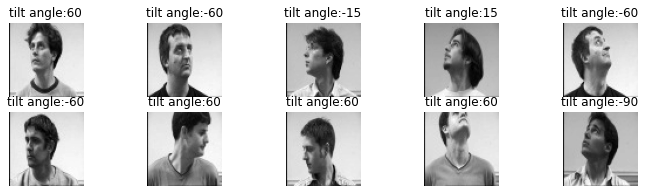

In [ ]:
from PIL import Image
random_image_list = dataframe.loc[np.random.choice(2325,10),'image_path']
plt.figure(figsize=(12,3))
for i, image_path in enumerate(random_image_list ):
    im = np.asarray(Image.open(image_path))
    plt.subplot(2,5,i+1)
    plt.imshow(im,cmap='gray')
    plt.title("tilt angle:"+str(final_tilt_predictions['tilt'][i]))

    plt.axis('off')  
plt.show()

In [ ]:
final_tilt_predictions.to_csv('s3763175_predictions.csv',index=False)